# DELE CA2 : Dueling Deep-Q Learning

## Motivation

> This notebook is dedicated to running the DDQN algorithm on the LunarLanderV2 environment and render a video of the spacecraft landing on the landing pad.

In [1]:
# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as keras
import gym

from tensorflow.python.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Replay Buffer and Experience Replay

> A buffer (temporary memory) of observations, rewards, and subsequent observations. The buffer is used to then train the Deep Learning model. 

The purpose of Experience Replay is to store past experiences and then using a random subset of these experiences to update the Q-network, rather than using just the single recent experience.

A replay buffer contains a collection of experience (State, Action, Reward, New State). Normally, a replay buffer is store as a queue, where new buffer is added to the end so that it pushes the oldest experience out of it.

In [2]:
# The ReplayBuffer class is used to store experiences in a buffer of size N. 
# The buffer is used to sample a batch of experiences from the buffer to train the agent.
class ReplayBuffer:
    def __init__(self, size, input_shape):
        self.size = size
        self.counter = 0
        self.state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.action_buffer = np.zeros(self.size, dtype=np.int32)
        self.reward_buffer = np.zeros(self.size, dtype=np.float32)
        self.new_state_buffer = np.zeros((self.size, *input_shape), dtype=np.float32)
        self.terminal_buffer = np.zeros(self.size, dtype=np.bool_)

    # insert experience into the buffer
    def store_tuples(self, state, action, reward, new_state, done):
        idx = self.counter % self.size
        self.state_buffer[idx] = state
        self.action_buffer[idx] = action
        self.reward_buffer[idx] = reward
        self.new_state_buffer[idx] = new_state
        self.terminal_buffer[idx] = done
        self.counter += 1

    # Sample a batch of experiences from the buffer
    def sample_buffer(self, batch_size):
        max_buffer = min(self.counter, self.size)
        batch = np.random.choice(max_buffer, batch_size, replace=False)
        state_batch = self.state_buffer[batch]
        action_batch = self.action_buffer[batch]
        reward_batch = self.reward_buffer[batch]
        new_state_batch = self.new_state_buffer[batch]
        done_batch = self.terminal_buffer[batch]

        return state_batch, action_batch, reward_batch, new_state_batch, done_batch

## Dueling DQN

The DDQN architecture slightly differs from the DQN architectures. It consists of two estimators - (1) the state value function, and (2) the state dependent action advatage function. These two estimators are combined to generated the action-value function. 

The benefit is that the state-value function is quicker and easier to learn, which leads to faster convergence.  


In [3]:
# The DuelingDQN class inherits from keras.Model.
# It has two dense layers, each followed by a relu activation.
# The V layer is a dense layer with 1 unit.
# The A layer is a dense layer with the same number of units as the action space.
# The output of the network is the sum of the output of the V and A layers.
class DuelingDQN(keras.Model):
    def __init__(self, num_actions, fc1, fc2):
        super(DuelingDQN, self).__init__()
        self.dense1 = Dense(fc1, activation='relu')
        self.dense2 = Dense(fc2, activation='relu')
        self.V = Dense(1, activation=None)
        self.A = Dense(num_actions, activation=None)

    def call(self, state):
        x = self.dense1(state)
        x = self.dense2(x)
        V = self.V(x)
        A = self.A(x)
        avg_A = tf.math.reduce_mean(A, axis=1, keepdims=True)
        Q = (V + (A - avg_A))

        return Q, A

# Agent

## Target Network

> A target network is a copy of the estimated value function that is held fixed to serve as a stable target for some number of steps.

When we alter the neural network parameters to $Q(s,a)$, it make alter $Q(s',a')$ and other states nearby, which is determined to make training very unstable.

To make training more stabel, copying over the Q Net over to the target network and use it for the $Q(s', a')$. 

## Policy

The policy takes the highest Q-value of the current state and chooses the action with the highest Q-value. For the first few episodes, the agent will explore the environment by randomly choosing actions.

$a \leftarrow argmax\ Q(s, a_s)$


In [4]:
# Agent Class
class Agent:
    def __init__(self, lr, discount_factor, num_actions, epsilon, batch_size, input_dim):
        self.action_space = [i for i in range(num_actions)]
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.batch_size = batch_size
        self.epsilon_decay = 0.001
        self.epsilon_final = 0.01
        self.update_rate = 120
        self.step_counter = 0
        self.buffer = ReplayBuffer(100000, input_dim)
        self.q_net = DuelingDQN(num_actions, 128, 128)
        self.q_target_net = DuelingDQN(num_actions, 128, 128)
        self.q_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')
        self.q_target_net.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    def store_tuple(self, state, action, reward, new_state, done):
        '''
        Store the tuple of the experience in the buffer.
        
        state: The state of the environment before the agent took the action
        action: The action taken by the agent in the current state
        reward: The reward received for performing an action in a state
        new_state: The state the agent is in after performing the action
        done: A boolean that indicates whether the episode has finished
        '''
        self.buffer.store_tuples(state, action, reward, new_state, done)

    def policy(self, observation):
         # Explores the env using random actions in the first few episodes
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.action_space)
        else:
            # Picks the action with the highest Q value
            state = np.array([observation])
            _, actions = self.q_net(state)
            action = tf.math.argmax(actions, axis=1).numpy()[0]

        return action

    def train(self):
        '''
        If the buffer has enough experience in it, and if it's time to update the target network, then
        update the target network
        :return: The agent's action.
        '''
        # If the replay buffer is less than the batch size, don't train
        if self.buffer.counter < self.batch_size:
            return
        
        
        # This is updating the weights of the target network. The target network is updated every
        # `update_rate` steps.
        if self.step_counter % self.update_rate == 0:
            self.q_target_net.set_weights(self.q_net.get_weights())
            
        # Sample a batch of experiences from the replay buffer
        state_batch, action_batch, reward_batch, new_state_batch, done_batch = self.buffer.sample_buffer(self.batch_size)

        # Get the Q values for the current states
        q_predicted, _ = self.q_net(state_batch)
        q_next, _ = self.q_target_net(new_state_batch)
        q_max_next = tf.math.reduce_max(q_next, axis=1, keepdims=True).numpy()
        q_target = np.copy(q_predicted)

        # Calculating the target Q value for the current state.
        for idx in range(done_batch.shape[0]):
            target_q_val = reward_batch[idx]
            if not done_batch[idx]:
                target_q_val += self.discount_factor*q_max_next[idx]
            q_target[idx, action_batch[idx]] = target_q_val
        self.q_net.train_on_batch(state_batch, q_target)
        self.epsilon = self.epsilon - self.epsilon_decay if self.epsilon > self.epsilon_final else self.epsilon_final
        self.step_counter += 1

    # Main Function to train DDQN
    def train_model(self, env, num_episodes, graph):
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        f = 0
        txt = open("saved_networks.txt", "w")

        # This is the code that is used to train the agent. The agent is trained for a number of episodes.
        for i in range(num_episodes):
            done = False
            score = 0.0
            state = env.reset()
            while not done:
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                score += reward
                self.store_tuple(state, action, reward, new_state, done)
                state = new_state
                self.train()
            scores.append(score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, score, self.epsilon,
                                                                             avg_score))
            
            # Saves the network's weights when avg score larger than 220 and score larger than 250
            if avg_score >= 220.0 and score >= 250:
                self.q_net.save(("saved_networks/duelingdqn_model{0}".format(f)))
                self.q_net.save_weights(("saved_networks/duelingdqn_model{0}/net_weights{0}.h5".format(f)))
                txt.write("Save {0} - Episode {1}/{2}, Score: {3} ({4}), AVG Score: {5}\n".format(f, i, num_episodes,
                                                                                                  score, self.epsilon,
                                                                                                  avg_score))
                f += 1
                print("Network saved")

        txt.close()
        
        # Creating Training Learning Curve
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            with plt.style.context('ggplot'):
                fig, ax = plt.subplots(figsize=(16, 9))
                plt.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
                plt.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                        label='AverageScore')
                plt.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                        label='Solved Requirement')
                plt.legend()
                plt.savefig('LunarLander_Train.png')

    # Main Function to test the trained DDQN on a rendered env
    def test(self, env, num_episodes, file_type, file, graph):
        # Loading the DDQN weights from the saved model
        if file_type == 'tf':
            self.q_net = tf.keras.models.load_model(file)
        elif file_type == 'h5':
            self.train_model(env, 5, False)
            self.q_net.load_weights(file)
        self.epsilon = 0.0
        scores, episodes, avg_scores, obj = [], [], [], []
        goal = 200
        score = 0.0
        for i in range(num_episodes):
            state = env.reset()
            done = False
            episode_score = 0.0
            while not done:
                env.render()
                action = self.policy(state)
                new_state, reward, done, _ = env.step(action)
                episode_score += reward
                state = new_state
            score += episode_score
            scores.append(episode_score)
            obj.append(goal)
            episodes.append(i)
            avg_score = np.mean(scores[-100:])
            avg_scores.append(avg_score)
            print("Episode {0}/{1}, Score: {2} ({3}), AVG Score: {4}".format(i, num_episodes, episode_score, self.epsilon, avg_score))


        # Create Test Learning Curve
        if graph:
            df = pd.DataFrame({'x': episodes, 'Score': scores, 'Average Score': avg_scores, 'Solved Requirement': obj})

            with plt.style.context('ggplot'):
                fig, ax = plt.subplots(figsize=(16, 9))
                ax.plot('x', 'Score', data=df, marker='', color='blue', linewidth=2, label='Score')
                ax.plot('x', 'Average Score', data=df, marker='', color='orange', linewidth=2, linestyle='dashed',
                        label='AverageScore')
                ax.plot('x', 'Solved Requirement', data=df, marker='', color='red', linewidth=2, linestyle='dashed',
                        label='Solved Requirement')
                ax.legend()
                fig.savefig('Test Learning Curve.png')

        env.close()

In [5]:
# Creating the environment and setting the specs for the environment
env = gym.make("LunarLander-v2")
spec = gym.spec("LunarLander-v2")
monitor = gym.wrappers.Monitor(env, './LunarLander_DDQN_Test', force=True)
num_episodes = 100
graph = True
file = "saved_networks/duelingdqn_model110"
file_type = 'tf'

# Creating an instance of the Agent class.
duelingdqn_agent = Agent(lr=0.00075, discount_factor=0.99, num_actions=4, epsilon=1.0, batch_size=64, input_dim=[8])

Episode 0/100, Score: 279.02556487602203 (0.0), AVG Score: 279.02556487602203
Episode 1/100, Score: 290.82958666189603 (0.0), AVG Score: 284.92757576895906
Episode 2/100, Score: 261.4739956314524 (0.0), AVG Score: 277.10971572312354
Episode 3/100, Score: 150.25269621645344 (0.0), AVG Score: 245.395460846456
Episode 4/100, Score: 279.67851044669624 (0.0), AVG Score: 252.25207076650403
Episode 5/100, Score: 248.5839869873378 (0.0), AVG Score: 251.64072346997634
Episode 6/100, Score: 273.5930298895761 (0.0), AVG Score: 254.77676724420488
Episode 7/100, Score: 268.3847993075946 (0.0), AVG Score: 256.4777712521286
Episode 8/100, Score: 249.8258475006441 (0.0), AVG Score: 255.73866861307476
Episode 9/100, Score: 284.693417284305 (0.0), AVG Score: 258.6341434801978
Episode 10/100, Score: 297.5866419141744 (0.0), AVG Score: 262.17527970146836
Episode 11/100, Score: 260.218396180103 (0.0), AVG Score: 262.0122060746879
Episode 12/100, Score: 260.2574599395034 (0.0), AVG Score: 261.8772256027506


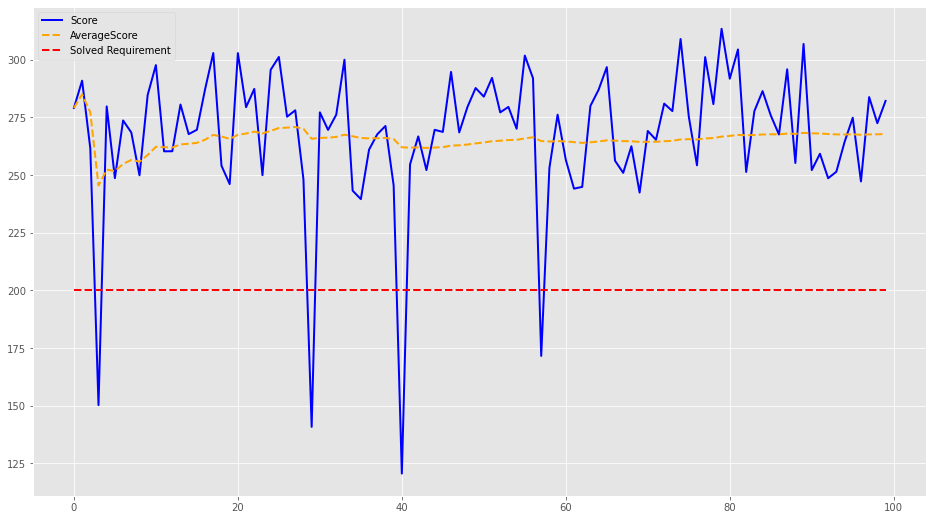

In [6]:
%%time
# Test DQN with rendered environment with video recording
duelingdqn_agent.test(monitor, num_episodes, file_type, file, graph)